Loading results...

Creating performance summary...

Aggregated Model Performance:
                               Median_RRMSE                  Q25    Q75
                                     median   mean    std median median
Model          Family Paradigm                                         
chain_ERCcv_lr linear chain           0.857  0.863  0.104  0.494  1.426
chain_ERCcv_rf tree   chain           0.897  0.901  0.070  0.620  1.256
global_rf      tree   global          0.929  0.926  0.054  0.689  1.203
local_lasso    linear local           0.853  0.852  0.099  0.497  1.321
local_rf       tree   local           0.906  0.909  0.066  0.626  1.253

Aggregating by family and paradigm...

Computing statistical comparisons...

Generating comparison bar plots...
Bar plots saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_2_pooling_families_cd/plots/family_paradigm_comparison.png


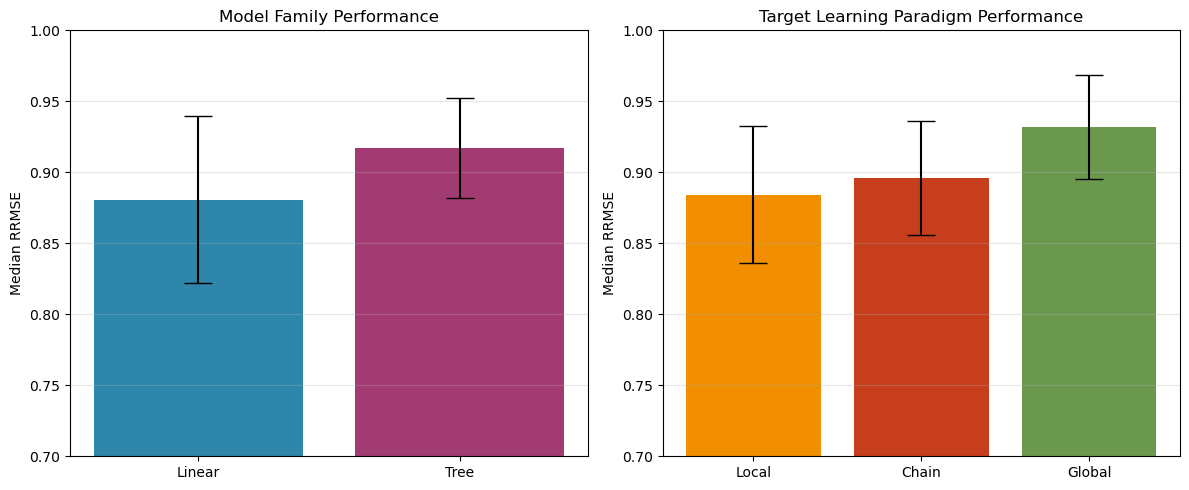


=== Model Family Comparison (per-target consistent) ===
Linear median RRMSE: 0.881
Tree-based median RRMSE: 0.917
Paired Wilcoxon p-value: 0.00012
Cliff's δ (targets): 0.755

=== Target Learning Paradigm Comparison (per-target consistent) ===
Local median RRMSE:  0.884
Chain median RRMSE:  0.896
Global median RRMSE: 0.932
Friedman χ² = 23.286, p = 0.00001

Performing post-hoc Nemenyi test for paradigms (consistent ranks)...
           Local     Chain    Global
Local   1.000000  0.285284  0.000007
Chain   0.285284  1.000000  0.003762
Global  0.000007  0.003762  1.000000

====== Model Family Comparison — Friedman/Nemenyi & extras ======

Median RRMSE per target:
linear    0.881
tree      0.917
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_2_pooling_families_cd/tables/A1_model_family_median.csv

Paired Wilcoxon (linear vs tree): p = 0.00012207

Wilcoxon pairwise p-values:
        linear    tree
linear  1.0000  0.0001
tree    0.0001  1.000

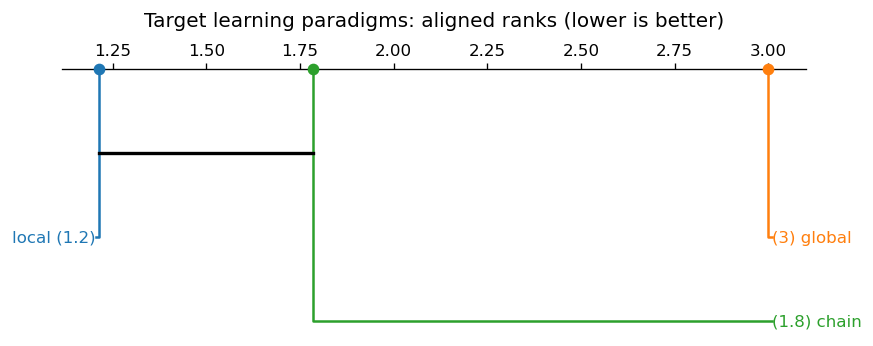

In [1]:
"""
f_2_pooling_families_cd.ipynb 
____________________________________________

Model-family vs learning-paradigm comparison (no fine-tuning).
We compare linear vs tree-based models and three multi-target paradigms
(local, chain, global) using LOOCV RRMSE arrays from the static and frozen
pipelines only (fine-tuned results are intentionally excluded).

This script:
1) Loads per-embedding LOOCV RRMSE dictionaries from disk:
   • Static: baseline {word2vec, fasttext}
     (tries 'baseline_<key>_loocv_rrmse.npy' and '<key>_loocv_rrmse.npy').
   • Frozen token/sentence encoders:
     {bert_*, robbert_v2_*, robbert2023_*, deberta_*, xlmr_large_*,
      rembert_*, sbert_bert, sbert_roberta, e5_base, e5_large, labse,
      simcse_xlmr_base}.
   Each file stores: model_key → ndarray of shape (folds × 14 targets).
2) Collapses folds→targets via median, aggregates per group by taking the
   per-target median across (embeddings × models in that group).
3) Runs per-target–consistent stats:
   • Model family (linear vs tree): paired Wilcoxon over targets + Cliff’s Δ.
   • Learning paradigm (local vs chain vs global): Friedman + post-hoc and
     pairwise Wilcoxon/ Holm + Cliff’s Δ.
4) Saves tables and renders CD diagrams and comparison bar charts.

Inputs:
- outputs/a_static/results/baseline_word2vec_loocv_rrmse.npy
- outputs/a_static/results/baseline_fasttext_loocv_rrmse.npy
- outputs/b_frozen/results/<embedding_key>_loocv_rrmse.npy
  (keys include mean|max|cls for token encoders and sentence encoders listed above)

Outputs (under outputs/f_final_report/f_2_pooling_families_cd/):
- tables/
  • model_performance_summary.csv
  • A1_model_family_median.csv
  • A1_model_family_wilcoxon_raw_p.csv
  • A1_model_family_wilcoxon_holm_p.csv
  • A1_model_family_cliffs_delta.csv
  • A1_paradigms_median.csv
  • A1_paradigms_wilcoxon_raw_p.csv
  • A1_paradigms_wilcoxon_holm_p.csv
  • A1_paradigms_cliffs_delta.csv
  • (if k≥3) A1_paradigms_nemenyi_p.csv or Conover p-values (Holm) where applicable
- plots/
  • family_paradigm_comparison.png
  • A1_paradigms_cd.png
  • (family CD is skipped gracefully for k=2)

Notes
• Folds are collapsed with the median; group aggregation across
  (embeddings × models in group) also uses medians per target.
• Fine-tuned results (outputs/d_fine_tuned) are intentionally not read.

"""
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy import stats
from pathlib import Path
from itertools import combinations
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

# ─────────────────────────────────────────────────────────────────────────────
# 1. PATHS & CONSTANTS
# ─────────────────────────────────────────────────────────────────────────────

def get_project_root(marker: str = "LICENSE") -> Path:
    cwd = Path.cwd().resolve()
    for cand in (cwd, *cwd.parents):
        if (cand / marker).is_file():
            return cand
    raise FileNotFoundError(f"Could not find '{marker}' in {cwd} or parents.")

ROOT = get_project_root()
os.chdir(ROOT)

OUT_ROOT = ROOT / "outputs"
STATIC_RESULTS_DIR = OUT_ROOT / "a_static" / "results"
FROZEN_RESULTS_DIR = OUT_ROOT / "b_frozen" / "results"

OUT_DIR    = OUT_ROOT / "f_final_report" / "f_2_pooling_families_cd"
PLOTS_DIR  = OUT_DIR / "plots"
TABLES_DIR = OUT_DIR / "tables"

for p in (PLOTS_DIR, TABLES_DIR):
    p.mkdir(parents=True, exist_ok=True)

N_TARGETS = 14

# ─────────────────────────────────────────────────────────────────────────────
# 2. HELPER FUNCTIONS (from interim_report)
# ─────────────────────────────────────────────────────────────────────────────

def _save_and_show(fig, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=120, bbox_inches="tight")
    print(f"\nCritical distance diagram plot")
    print(f"Plot saved → {path}")
    plt.show()  

def infer_n_targets(results_dict, models_priority):
    """Peek the first available array to infer #targets."""
    for emb in results_dict:
        for m in models_priority:
            if m in results_dict[emb]:
                arr = results_dict[emb][m]
                # arr may be (folds, targets) or already (targets,)
                return arr.shape[-1]
    raise ValueError("Could not infer number of targets from results.")
    

def load_model_results(embeddings, models):
    """
    Load RRMSE dicts for given embeddings/models from:
      - outputs/a_static/results  (static: tries baseline_<key>_... then <key>_...)
      - outputs/b_frozen/results  (frozen: <key>_loocv_rrmse.npy)
    Returns: {embedding_key: {model_key: (folds × targets) ndarray}}
    """
    results = {}
    for emb in embeddings:
        if emb in {"word2vec", "fasttext"}:
            candidates = [
                STATIC_RESULTS_DIR / f"baseline_{emb}_loocv_rrmse.npy",
                STATIC_RESULTS_DIR / f"{emb}_loocv_rrmse.npy",
            ]
        else:
            candidates = [FROZEN_RESULTS_DIR / f"{emb}_loocv_rrmse.npy"]

        loaded = None
        for path in candidates:
            if path.exists():
                try:
                    data = np.load(path, allow_pickle=True).item()
                    subset = {m: data[m] for m in models if m in data}
                    if subset:
                        results[emb] = subset
                        loaded = path
                    break
                except Exception as e:
                    print(f"⚠ Failed loading {path.name}: {e}")
        if loaded is None:
            # keep quiet if truly absent; this function is tolerant to missing keys
            pass

    if not results:
        raise FileNotFoundError(
            f"No LOOCV RRMSE files found for the requested embeddings/models.\n"
            f"Looked under:\n  {STATIC_RESULTS_DIR}\n  {FROZEN_RESULTS_DIR}"
        )
    return results

def aligned_ranks(mat):
	"""Hodges–Lehmann alignment + ranking along rows"""
	aligned = mat - np.median(mat, axis=1, keepdims=True)
	return np.apply_along_axis(lambda r: np.argsort(np.argsort(r)) + 1, 1, aligned)
 
def friedman_aligned(mat):
	"""Aligned-Friedman χ² and Iman-Davenport F-statistic"""
	k = mat.shape[1]
	chi2, _ = friedmanchisquare(*[mat[:, i] for i in range(k)])
	Ff = ((mat.shape[0] - 1) * chi2) / (mat.shape[0] * (k - 1) - chi2)
	return chi2, Ff
 
def wilcoxon_matrix(mat, labels):
    """Pairwise two-sided Wilcoxon (zero-method = zsplit)"""
    df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for i, j in combinations(range(len(labels)), 2):
        diff = mat[:, i] - mat[:, j]
        p = 1.0 if np.allclose(diff, 0) else wilcoxon(diff, zero_method="zsplit")[1]
        df.iat[i, j] = df.iat[j, i] = p
    return df.round(4)
 
def holm_correct_and_effects(raw_p, data, labels):
    """Holm–Bonferroni correction and Cliff's Delta effect sizes"""
    idx = list(combinations(range(len(labels)), 2))
    pvals = [raw_p.iat[i,j] for i,j in idx]
    
    rej, p_adj, _, _ = multipletests(pvals, method="holm")
    
    adj_df = raw_p.copy()
    for (i,j), p in zip(idx, p_adj):
        adj_df.iat[i,j] = adj_df.iat[j,i] = p
    adj_df[np.eye(len(labels),dtype=bool)] = 1.0
    
    def cliffs_delta(x,y):
        diffs = np.subtract.outer(x, y)
        n = len(x)*len(y)
        return (np.sum(diffs>0) - np.sum(diffs<0)) / n
    
    delta_df = pd.DataFrame(
        np.ones((len(labels),len(labels))),
        index=labels, columns=labels
    )
    
    for (i,j) in idx:
        d_ij = cliffs_delta(data[:,i], data[:,j])
        delta_df.iat[i,j] = d_ij
        delta_df.iat[j,i] = -d_ij
    
    return adj_df.round(4), delta_df.round(3)
 
def conover_posthoc(ranks, labels, fname_tag):
	"""Conover–Iman test with Holm correction"""
	p_df = sp.posthoc_conover_friedman(ranks, p_adjust="holm")
	p_df.index = p_df.columns = labels
	out = TABLES_DIR / f"{fname_tag}_conover_p.csv"
	p_df.to_csv(out)
	print("\nConover–Iman post-hoc p-values (Holm-adjusted):")
	print(p_df.round(4).to_string())
	print("  ↳ saved →", out)
	return p_df
 
def run_friedman(mat, block_name, col_labels, fname_tag):
    """Generic routine for Friedman analysis with post-hoc tests.

    - Always writes medians to  {TABLES_DIR}/{fname_tag}_median.csv
    - If k == 2 (e.g., linear vs tree), writes:
        * {fname_tag}_wilcoxon_raw_p.csv
        * {fname_tag}_wilcoxon_holm_p.csv
        * {fname_tag}_cliffs_delta.csv
      and prints them to console.
    - If k >= 3, runs the regular Friedman + post-hoc pipeline you already had.
    """
    k = len(col_labels)
    nblocks = mat.shape[0]

    # Save & print medians
    col_meds = pd.Series(np.median(mat, axis=0), index=col_labels)
    med_path = TABLES_DIR / f"{fname_tag}_median.csv"
    col_meds.to_csv(med_path, header=["median_rrmse"])
    print(f"\nMedian RRMSE per {block_name[:-1] if block_name.endswith('s') else block_name}:")
    print(col_meds.round(3).to_string())
    print("  ↳ saved →", med_path)

    # Special handling for 2-method comparisons (e.g., linear vs tree)
    if k == 2:
        x = mat[:, 0]
        y = mat[:, 1]
        p = wilcoxon(x, y, zero_method="zsplit")[1]
        print(f"\nPaired Wilcoxon ({col_labels[0]} vs {col_labels[1]}): p = {p:.5g}")

        # 1) Raw p-value matrix
        raw = np.eye(2, dtype=float)
        raw[0, 1] = raw[1, 0] = p
        raw_df = pd.DataFrame(raw, index=col_labels, columns=col_labels).round(4)
        raw_path = TABLES_DIR / f"{fname_tag}_wilcoxon_raw_p.csv"
        raw_df.to_csv(raw_path)
        print("\nWilcoxon pairwise p-values:")
        print(raw_df.to_string())
        print("  ↳ saved →", raw_path)

        # 2) Holm–Bonferroni (same as raw with a single comparison, but we persist it)
        _, p_adj, _, _ = multipletests([p], method="holm")
        holm = np.eye(2, dtype=float)
        holm[0, 1] = holm[1, 0] = p_adj[0]
        holm_df = pd.DataFrame(holm, index=col_labels, columns=col_labels).round(4)
        holm_path = TABLES_DIR / f"{fname_tag}_wilcoxon_holm_p.csv"
        holm_df.to_csv(holm_path)
        print("\nHolm–Bonferroni adjusted p-values:")
        print(holm_df.to_string())
        print("  ↳ saved →", holm_path)

        # 3) Cliff's Δ matrix
        d = compute_cliff_delta(x, y)
        delta = np.eye(2, dtype=float)
        delta[0, 1] = d
        delta[1, 0] = -d
        delta_df = pd.DataFrame(delta, index=col_labels, columns=col_labels).round(3)
        delta_path = TABLES_DIR / f"{fname_tag}_cliffs_delta.csv"
        delta_df.to_csv(delta_path)
        print("\nCliff's Δ effect sizes:")
        print(delta_df.to_string())
        print("  ↳ saved →", delta_path)

        return  # done for k==2

    # (rare) If you ever truly have only two blocks, keep a graceful exit.
    if nblocks == 2:
        print(f"\nOnly two {block_name} → skipping Friedman/post-hoc.")
        return

    # k >= 3: Friedman + post-hoc (your original logic)
    ranks = aligned_ranks(mat)
    chi2_a, Ff_a = friedman_aligned(ranks)
    chi2_o, p_o = friedmanchisquare(*[mat[:, i] for i in range(k)])
    Ff_o = ((nblocks - 1) * chi2_o) / (nblocks * (k - 1) - chi2_o)

    print(f"\n*Aligned-Friedman* (blocks = {block_name})")
    print(f"  χ²_F = {chi2_a:.3f}    F_F = {Ff_a:.3f}")
    print(f"\n*Original-Friedman* (blocks = {block_name})")
    print(f"  χ²_F = {chi2_o:.3f}    p = {p_o:.3g}    F_F = {Ff_o:.3f}")

    if nblocks < 10:
        conover_posthoc(ranks, col_labels, fname_tag)
    else:
        pvals_nem = sp.posthoc_nemenyi_friedman(ranks)
        pvals_nem.index = pvals_nem.columns = col_labels
        nem_path = TABLES_DIR / f"{fname_tag}_nemenyi_p.csv"
        pvals_nem.to_csv(nem_path)
        print("\nNemenyi p-values (aligned post-hoc):")
        print(pvals_nem.round(4).to_string())
        print("  ↳ saved →", nem_path)

    # Pairwise Wilcoxon (matrix), Holm, and Cliff's Δ (for k>=3 case)
    wilc = wilcoxon_matrix(mat, col_labels)
    print("\nWilcoxon pairwise p-values:")
    print(wilc.round(4).to_string())
    wilc_path = TABLES_DIR / f"{fname_tag}_wilcoxon_raw_p.csv"
    wilc.to_csv(wilc_path)
    print("  ↳ saved →", wilc_path)

    adj, delta = holm_correct_and_effects(wilc, mat, col_labels)
    print("\nHolm–Bonferroni adjusted p-values:")
    print(adj.round(4).to_string())
    adj_path = TABLES_DIR / f"{fname_tag}_wilcoxon_holm_p.csv"
    adj.to_csv(adj_path)
    print("  ↳ saved →", adj_path)

    print("\nCliff's Δ effect sizes:")
    print(delta.round(3).to_string())
    delta_path = TABLES_DIR / f"{fname_tag}_cliffs_delta.csv"
    delta.to_csv(delta_path)
    print("  ↳ saved →", delta_path)


# ─────────────────────────────────────────────────────────────────────────────
# 3. ANALYSIS FUNCTIONS
# ─────────────────────────────────────────────────────────────────────────────
 
def vector_per_target(rrmse_array):
	"""Collapse (folds × targets) → (targets,) by median across folds"""
	return np.median(rrmse_array, axis=0) if rrmse_array.ndim == 2 else rrmse_array
 
def matrix_per_target_compare_models(data_dict, model_list, embedding_list):
	"""Build matrix: rows = targets, cols = models, aggregated across embeddings"""
	return np.column_stack([
    	np.median(
        	np.concatenate([
            	vector_per_target(data_dict[emb][model])
            	for emb in embedding_list if emb in data_dict
        	], axis=0).reshape(-1, N_TARGETS),
        	axis=0
    	)
    	for model in model_list
	])
 

def cd_plot(matrix, labels, title, fname):
    """Draw a critical-distance diagram with spurious line prevention"""
    if matrix.shape[1] < 2:
        print(f"⚠  Skipping CD-plot '{title}' (need ≥2 methods, got {matrix.shape[1]})")
        return
    
    ranks = aligned_ranks(matrix)
    pvals = sp.posthoc_nemenyi_friedman(ranks)
    
    # Clean up p-values to prevent spurious lines
    # Convert to DataFrame if not already
    if not isinstance(pvals, pd.DataFrame):
        pvals = pd.DataFrame(pvals)
    
    # Ensure symmetric matrix and proper diagonal
    pvals = pvals.fillna(1.0)
    np.fill_diagonal(pvals.values, 1.0)
    
    # Make symmetric (take minimum of upper and lower triangle)
    pvals_array = pvals.values
    pvals_clean = np.minimum(pvals_array, pvals_array.T)
    pvals = pd.DataFrame(pvals_clean, index=labels, columns=labels)
    
    fig, ax = plt.subplots(figsize=(8, 3), dpi=120)
    
    # Call with clean p-values
    sp.critical_difference_diagram(
        pd.Series(ranks.mean(0), index=labels), 
        pvals, 
        ax=ax
    )
    ax.set_title(title, pad=10)
    _save_and_show(fig, PLOTS_DIR / fname)

 
def cd_plot_dual(matrix1, labels1, matrix2, labels2, title1, title2, fname):
    """Draw two critical-distance diagrams side by side"""
    # need at least two methods in each matrix
    if matrix1.shape[1] < 2 or matrix2.shape[1] < 2:
        print("⚠  Skipping dual CD-plot (need ≥2 methods for both)")
        return

    ranks1 = aligned_ranks(matrix1)
    pvals1 = sp.posthoc_nemenyi_friedman(ranks1)
    ranks2 = aligned_ranks(matrix2)
    pvals2 = sp.posthoc_nemenyi_friedman(ranks2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3), dpi=120)

    sp.critical_difference_diagram(
        pd.Series(ranks1.mean(0), index=labels1), pvals1, ax=ax1
    )
    ax1.set_title(title1, pad=10)

    sp.critical_difference_diagram(
        pd.Series(ranks2.mean(0), index=labels2), pvals2, ax=ax2
    )
    ax2.set_title(title2, pad=10)

    plt.tight_layout()
    _save_and_show(fig, PLOTS_DIR / fname)


def aggregate_by_family_and_paradigm(results, model_metadata, embeddings, models):
    """
    Return per-target arrays for each family/paradigm, consistent with the
    Friedman setup (targets are blocks).

    For each group:
      - collapse (folds, targets) -> (targets,) by median across folds
      - concatenate across (embeddings × models in group)
      - take median across the concatenated samples, per target
    """
    family_labels   = ['linear', 'tree']
    paradigm_labels = ['local', 'chain', 'global']

    family_matrix = stack_per_group(
        results=results,
        embeddings=embeddings,
        model_metadata=model_metadata,
        group_key='family',
        group_values=family_labels,
        all_models=models
    )
    paradigm_matrix = stack_per_group(
        results=results,
        embeddings=embeddings,
        model_metadata=model_metadata,
        group_key='paradigm',
        group_values=paradigm_labels,
        all_models=models
    )

    # expose per-target vectors for downstream stats
    family_results = {lab: family_matrix[:, i] for i, lab in enumerate(family_labels)}
    paradigm_results = {lab: paradigm_matrix[:, i] for i, lab in enumerate(paradigm_labels)}

    return family_results, paradigm_results, family_matrix, paradigm_matrix, family_labels, paradigm_labels

def compute_family_paradigm_stats(family_results, paradigm_results):
    """Compute stats using per-target vectors (targets as blocks)."""
    stats_results = {}

    # --- family: paired Wilcoxon over targets ---
    linear_vec = np.asarray(family_results['linear'])
    tree_vec   = np.asarray(family_results['tree'])

    stat, p_value = wilcoxon(linear_vec, tree_vec, zero_method="zsplit")

    stats_results['family'] = {
        'linear_median': float(np.nanmedian(linear_vec)),
        'tree_median':   float(np.nanmedian(tree_vec)),
        'wilcoxon_stat': stat,
        'p_value':       float(p_value),
        'effect_size':   compute_cliff_delta(linear_vec, tree_vec)  # Cliff's Δ over targets
    }

    # --- paradigms: Friedman over targets ---
    par_mat = np.column_stack([
        np.asarray(paradigm_results['local']),
        np.asarray(paradigm_results['chain']),
        np.asarray(paradigm_results['global']),
    ])

    chi2, p_value = friedmanchisquare(par_mat[:, 0], par_mat[:, 1], par_mat[:, 2])

    stats_results['paradigm'] = {
        'local_median':  float(np.nanmedian(par_mat[:, 0])),
        'chain_median':  float(np.nanmedian(par_mat[:, 1])),
        'global_median': float(np.nanmedian(par_mat[:, 2])),
        'friedman_chi2': float(chi2),
        'p_value':       float(p_value),
    }

    return stats_results


def compute_cliff_delta(x, y):
    """Compute Cliff's delta effect size."""
    n1, n2 = len(x), len(y)
    dominance = sum(1 if xi < yi else 0.5 if xi == yi else 0 
                   for xi in x for yi in y)
    return 2 * dominance / (n1 * n2) - 1

def create_performance_table(results, model_metadata):
    """Create summary performance table."""
    summary = []
    
    for emb, models in results.items():
        for model, rrmse in models.items():
            if model == 'local_mean':
                continue
            
            median_rrmse = np.median(rrmse.flatten())
            q25 = np.percentile(rrmse.flatten(), 25)
            q75 = np.percentile(rrmse.flatten(), 75)
            
            summary.append({
                'Embedding': emb,
                'Model': model,
                'Family': model_metadata[model]['family'],
                'Paradigm': model_metadata[model]['paradigm'],
                'Median_RRMSE': median_rrmse,
                'Q25': q25,
                'Q75': q75
            })
    
    df = pd.DataFrame(summary)
    
    # Aggregate across embeddings
    agg_table = df.groupby(['Model', 'Family', 'Paradigm']).agg({
        'Median_RRMSE': ['median', 'mean', 'std'],
        'Q25': 'median',
        'Q75': 'median'
    }).round(3)
    
    return df, agg_table

def collapse_to_targets(rrmse):
    """From (folds, targets) -> (targets,) by median over folds."""
    return np.median(rrmse, axis=0) if rrmse.ndim == 2 else rrmse

def stack_per_group(results, embeddings, model_metadata, group_key, group_values, all_models):
    """
    Build a matrix (rows=targets, cols=len(group_values)) by:
      - for each group value (e.g., 'local', 'chain', 'global' OR 'linear','tree'):
          * for every embedding and every model in that group:
              - reduce (folds,targets) -> (targets,) by median across folds
          * concatenate all vectors across (embeddings x models in group)
          * take median across the concatenated dimension, per target
    """
    # infer #targets robustly
    n_targets = infer_n_targets(results, all_models)
    cols = []
    for gv in group_values:
        per_target_vectors = []
        for emb in embeddings:
            if emb not in results:
                continue
            for m in all_models:
                if m not in results[emb]:
                    continue
                if m == "local_mean":
                    continue
                if model_metadata[m][group_key] != gv:
                    continue
                per_target_vectors.append(collapse_to_targets(results[emb][m]))
        if len(per_target_vectors) == 0:
            # fall back to NaNs to avoid crashes
            cols.append(np.full(n_targets, np.nan))
        else:
            # concatenate along rows, take per-target median
            mat = np.vstack(per_target_vectors)  # shape (S, targets)
            cols.append(np.nanmedian(mat, axis=0))
    return np.column_stack(cols)  # (targets, len(group_values))

def plot_family_paradigm_comparison(family_matrix, paradigm_matrix, family_labels, paradigm_labels):
    """
    Bar charts using the same per-target aggregation used for Friedman:
      - `family_matrix`: shape (n_targets, len(family_labels))
      - `paradigm_matrix`: shape (n_targets, len(paradigm_labels))
    Medians and error bars are computed across targets.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # --- Family comparison ---
    fam_meds = np.nanmedian(family_matrix, axis=0)
    fam_stds = np.nanstd(family_matrix, axis=0)
    families = [lab.capitalize() for lab in family_labels]
    ax1.bar(families, fam_meds, yerr=fam_stds, capsize=10,
            color=['#2E86AB', '#A23B72'])
    ax1.set_ylabel('Median RRMSE')
    ax1.set_title('Model Family Performance')
    ax1.set_ylim([0.7, 1.0])
    ax1.grid(axis='y', alpha=0.3)

    # --- Paradigm comparison ---
    par_meds = np.nanmedian(paradigm_matrix, axis=0)
    par_stds = np.nanstd(paradigm_matrix, axis=0)
    paradigms = [lab.capitalize() for lab in paradigm_labels]
    ax2.bar(paradigms, par_meds, yerr=par_stds, capsize=10,
            color=['#F18F01', '#C73E1D', '#6A994E'])
    ax2.set_ylabel('Median RRMSE')
    ax2.set_title('Target Learning Paradigm Performance')
    ax2.set_ylim([0.7, 1.0])
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

def build_dispersion_succes_rate_metrics_5_1(verbose: bool = True):
    """
    Build §5.1 robust-dispersion and success-rate tables grouped by
    *model family* (linear/tree) and *paradigm* (local/chain/global).

    Reads (from §4.7):
      - output/g_figures_paper/section_4_7/tables/S2_robust_dispersion_per_model.csv
      - output/g_figures_paper/section_4_7/tables/S1_poi_success_per_model.csv

    Writes (here):
      - Table_5_2_robust_dispersion_by_family.csv
      - Table_5_3_robust_dispersion_by_paradigm.csv
      - Table_5_4_success_by_family.csv
      - Table_5_5_success_by_paradigm.csv
    """
    SRC_47_TABLES = ROOT / "output" / "g_figures_paper" / "section_4_7" / "tables"
    PLOTS_DIR.mkdir(parents=True, exist_ok=True)
    TABLES_DIR.mkdir(parents=True, exist_ok=True)

    # ----- canonical §5.1 model set -----
    VALID_MODEL_KEYS = {
        "local_lasso",
        "local_rf",
        "chain_erccv_lr",
        "chain_erccv_rf",
        "global_rf",
        # "local_mean" is a baseline; excluded below
    }

    # ---------- helpers ----------
    def _parse_model_key(s: str) -> str:
        # label looks like: "<approach>|<embedding>|<model_key>"
        parts = str(s).split("|")
        key = parts[-1].strip().lower() if parts else str(s).strip().lower()
        return key

    paradigm_map = {
        "local_lasso": "local",
        "local_rf": "local",
        "local_mean": "local",      # baseline; will be dropped
        "chain_erccv_lr": "chain",
        "chain_erccv_rf": "chain",
        "global_rf": "global",
    }
    family_map = {
        "local_lasso": "linear",
        "chain_erccv_lr": "linear",
        "local_rf": "tree",
        "chain_erccv_rf": "tree",
        "global_rf": "tree",
        "local_mean": "baseline",   # excluded
    }

    def _ensure_meta_cols(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        if "label" not in df.columns:
            raise ValueError("Expected a 'label' column to derive model metadata.")
        df["model_key"] = df["label"].apply(_parse_model_key)

        # derive approach/paradigm/family
        if "family" in df.columns:
            # In §4.7 this is the *approach* (frozen/static/ftaug/ftorig)
            vals = set(df["family"].astype(str).str.lower().unique())
            if vals.issubset({"frozen", "static", "ftaug", "ftorig"}):
                df = df.rename(columns={"family": "approach"})
        df["paradigm"] = df["model_key"].map(paradigm_map)
        df["model_family"] = df["model_key"].map(family_map)

        # filter to §5.1 models only (drop partial_ft etc.)
        pre_keys = set(df["model_key"].unique())
        df = df[df["model_key"].isin(VALID_MODEL_KEYS | {"local_mean"})].copy()
        dropped = sorted(pre_keys - set(df["model_key"].unique()))
        if verbose and dropped:
            print(f"§5.1 filter: dropping {len(dropped)} model_key(s) not in scope:", dropped)

        # exclude the baseline from §5.1 summaries
        df = df[df["model_key"] != "local_mean"].copy()
        return df

    # ---------- load & prepare dispersion ----------
    disp_path = SRC_47_TABLES / "S2_robust_dispersion_per_model.csv"
    if not disp_path.exists():
        raise FileNotFoundError(f"Missing source table: {disp_path}")
    disp = pd.read_csv(disp_path)
    disp = _ensure_meta_cols(disp)

    cols_disp = ["median_IQR", "median_MAD", "median_P90"]
    missing = [c for c in cols_disp if c not in disp.columns]
    if missing:
        raise ValueError(f"Expected columns not found in {disp_path.name}: {missing}")

    if disp.empty:
        raise ValueError("No rows left for §5.1 after filtering dispersion table.")

    # Table 5.2 — robust dispersion by *model family*
    t52 = (disp.groupby("model_family")[cols_disp]
               .median()
               .reindex(["linear", "tree"])
               .round(3)
               .reset_index())
    t52_path = TABLES_DIR / "Table_5_2_robust_dispersion_by_family.csv"
    t52.to_csv(t52_path, index=False)

    # Table 5.3 — robust dispersion by *paradigm*
    t53 = (disp.groupby("paradigm")[cols_disp]
               .median()
               .reindex(["local", "chain", "global"])
               .round(3)
               .reset_index())
    t53_path = TABLES_DIR / "Table_5_3_robust_dispersion_by_paradigm.csv"
    t53.to_csv(t53_path, index=False)

    # ---------- load & prepare success rates ----------
    succ_path = SRC_47_TABLES / "S1_poi_success_per_model.csv"
    if not succ_path.exists():
        raise FileNotFoundError(f"Missing source table: {succ_path}")
    succ = pd.read_csv(succ_path)

    # tolerate alternate column spellings
    succ = succ.rename(columns={"s_at_0.90": "s_at_0p90", "s_at_0.80": "s_at_0p80"})
    for c in ["poi", "s_at_0p90", "s_at_0p80"]:
        if c not in succ.columns:
            raise ValueError(f"Expected column '{c}' in {succ_path.name}")

    succ = _ensure_meta_cols(succ)
    if succ.empty:
        raise ValueError("No rows left for §5.1 after filtering success table.")

    # Table 5.4 — success by *model family*
    t54 = (succ.groupby("model_family")[["poi", "s_at_0p90", "s_at_0p80"]]
               .mean()
               .reindex(["linear", "tree"])
               .round(3)
               .reset_index())
    t54_path = TABLES_DIR / "Table_5_4_success_by_family.csv"
    t54.to_csv(t54_path, index=False)

    # Table 5.5 — success by *paradigm*
    t55 = (succ.groupby("paradigm")[["poi", "s_at_0p90", "s_at_0p80"]]
               .mean()
               .reindex(["local", "chain", "global"])
               .round(3)
               .reset_index())
    t55_path = TABLES_DIR / "Table_5_5_success_by_paradigm.csv"
    t55.to_csv(t55_path, index=False)

    print("✓ Wrote:", t52_path); print(t52.to_string(index=False))
    print("\n✓ Wrote:", t53_path); print(t53.to_string(index=False))
    print("\n✓ Wrote:", t54_path); print(t54.to_string(index=False))
    print("\n✓ Wrote:", t55_path); print(t55.to_string(index=False))

    return {
        "t52_dispersion_by_family": t52,
        "t53_dispersion_by_paradigm": t53,
        "t54_success_by_family": t54,
        "t55_success_by_paradigm": t55,
    }


# ─────────────────────────────────────────────────────────────────────────────
# 4. MAIN
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Define embeddings and models
    embeddings = ['word2vec', 'fasttext'] + \
                 ['bert_mean', 'bert_max', 'bert_cls',
                  'robbert_v2_mean', 'robbert_v2_max', 'robbert_v2_cls',
                  'robbert2023_mean', 'robbert2023_max', 'robbert2023_cls',
                  'deberta_mean', 'deberta_max', 'deberta_cls',
                  'xlmr_large_mean', 'xlmr_large_max', 'xlmr_large_cls',
                  'rembert_mean', 'rembert_max', 'rembert_cls',
                  'sbert_bert', 'sbert_roberta', 'e5_base', 'e5_large',
                  'labse', 'simcse_xlmr_base']
    
    models = ['local_mean', 'local_lasso', 'local_rf',
              'chain_ERCcv_rf', 'chain_ERCcv_lr', 'global_rf']
    
    # Model metadata
    model_metadata = {
        'local_mean': {'family': 'baseline', 'paradigm': 'baseline'},
        'local_lasso': {'family': 'linear', 'paradigm': 'local'},
        'local_rf': {'family': 'tree', 'paradigm': 'local'},
        'chain_ERCcv_lr': {'family': 'linear', 'paradigm': 'chain'},
        'chain_ERCcv_rf': {'family': 'tree', 'paradigm': 'chain'},
        'global_rf': {'family': 'tree', 'paradigm': 'global'}
    }
    
    # Load results
    print("Loading results...")
    results = load_model_results(embeddings, models)
    N_TARGETS = infer_n_targets(results, models)
    
    # Create performance table
    print("\nCreating performance summary...")
    df_full, agg_table = create_performance_table(results, model_metadata)
    print("\nAggregated Model Performance:")
    print(agg_table)
    
    # Save to CSV
    agg_table.to_csv(TABLES_DIR / "model_performance_summary.csv")
    
    # Build per-target group data consistent with Friedman
    print("\nAggregating by family and paradigm...")
    (family_results, paradigm_results,
     family_matrix, paradigm_matrix,
     family_labels, paradigm_labels) = aggregate_by_family_and_paradigm(
        results, model_metadata, embeddings, models
    )

    print("\nComputing statistical comparisons...")
    stats_results = compute_family_paradigm_stats(family_results, paradigm_results)

    print("\nGenerating comparison bar plots...")
    fig = plot_family_paradigm_comparison(
        family_matrix, paradigm_matrix, family_labels, paradigm_labels
    )
    bar_path = PLOTS_DIR / "family_paradigm_comparison.png"
    fig.savefig(bar_path, dpi=120, bbox_inches="tight")
    print(f"Bar plots saved → {bar_path}")
    plt.show()

    print("\n=== Model Family Comparison (per-target consistent) ===")
    print(f"Linear median RRMSE: {stats_results['family']['linear_median']:.3f}")
    print(f"Tree-based median RRMSE: {stats_results['family']['tree_median']:.3f}")
    print(f"Paired Wilcoxon p-value: {stats_results['family']['p_value']:.5f}")
    print(f"Cliff's δ (targets): {stats_results['family']['effect_size']:.3f}")

    print("\n=== Target Learning Paradigm Comparison (per-target consistent) ===")
    print(f"Local median RRMSE:  {stats_results['paradigm']['local_median']:.3f}")
    print(f"Chain median RRMSE:  {stats_results['paradigm']['chain_median']:.3f}")
    print(f"Global median RRMSE: {stats_results['paradigm']['global_median']:.3f}")
    print(f"Friedman χ² = {stats_results['paradigm']['friedman_chi2']:.3f}, "
          f"p = {stats_results['paradigm']['p_value']:.5f}")

    # Optional: post-hoc using the same ranks as run_friedman
    if stats_results['paradigm']['p_value'] < 0.05:
        print("\nPerforming post-hoc Nemenyi test for paradigms (consistent ranks)...")
        ranks = aligned_ranks(paradigm_matrix)
        nem = sp.posthoc_nemenyi_friedman(ranks)
        nem.index = nem.columns = [lab.capitalize() for lab in paradigm_labels]
        print(nem.round(6))


    # ─────────────────────────────────────────────────────────────────────────────
    # Friedman/Nemenyi + CD plots for (a) Model Family and (b) Learning Paradigm
    # ─────────────────────────────────────────────────────────────────────────────

    # Prepare labels
    family_labels   = ["linear", "tree"]
    paradigm_labels = ["local", "chain", "global"]

    # Build matrices (rows = targets, cols = groups)
    family_matrix = stack_per_group(
        results=results,
        embeddings=embeddings,
        model_metadata=model_metadata,
        group_key="family",
        group_values=family_labels,
        all_models=models
    )

    paradigm_matrix = stack_per_group(
        results=results,
        embeddings=embeddings,
        model_metadata=model_metadata,
        group_key="paradigm",
        group_values=paradigm_labels,
        all_models=models
    )

    # --- (a) MODEL FAMILY COMPARISON ---
    print("\n" + "="*6 + " Model Family Comparison — Friedman/Nemenyi & extras " + "="*6)
    # Save descriptive medians + do Wilcoxon (k=2 triggers the Wilcoxon path in run_friedman)
    run_friedman(
        mat=family_matrix,
        block_name="targets",
        col_labels=family_labels,
        fname_tag="A1_model_family"
    )

    # CD diagram: only meaningful for k >= 3; with k=2 we'll skip gracefully
    if family_matrix.shape[1] >= 3 and not np.isnan(family_matrix).all():
        cd_plot(
            matrix=family_matrix,
            labels=family_labels,
            title="Model families: aligned ranks (lower is better)",
            fname="A1_model_family_cd.png"
        )

    # --- (b) TARGET LEARNING PARADIGM COMPARISON ---
    print("\n" + "="*6 + " Target Learning Paradigm Comparison — Friedman/Nemenyi & extras " + "="*6)
    run_friedman(
        mat=paradigm_matrix,
        block_name="targets",
        col_labels=paradigm_labels,
        fname_tag="A1_paradigms"
    )

    # CD diagram (k=3: normal)
    cd_plot(
        matrix=paradigm_matrix,
        labels=paradigm_labels,
        title="Target learning paradigms: aligned ranks (lower is better)",
        fname="A1_paradigms_cd.png"
    )